In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from attack_utils import *

/Users/marvinli/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
all_likelihoods = torch.load("70m_0.005_15.pt")
train_likelihoods = all_likelihoods[:all_likelihoods.shape[0]//2,]
valid_likelihoods = all_likelihoods[all_likelihoods.shape[0]//2:,]

In [53]:
train_mope = -(train_likelihoods[1:,:].mean(dim=0) - train_likelihoods[0,:])
valid_mope = -(valid_likelihoods[1:,:].mean(dim=0) - valid_likelihoods[0,:])

z_scores = stats.zscore(torch.concat((train_mope, valid_mope)))
train_mope_z = z_scores[:len(z_scores)//2] + min(z_scores)
valid_mope_z = z_scores[len(z_scores)//2:] + min(z_scores)

In [54]:
loss_z_scores = stats.zscore(torch.concat((train_likelihoods[0,:], valid_likelihoods[0,:])))
train_loss_z  = loss_z_scores[:len(loss_z_scores)//2] + min(loss_z_scores)
valid_loss_z  = loss_z_scores[len(loss_z_scores)//2:] + min(loss_z_scores)

In [55]:
def find_best_lambda(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z, stepsize = 0.01):
    best_lmbda = -1
    best_auc   = 0
    for lmbda in np.arange(0,1,stepsize):
        train_mix = train_mope_z * lmbda + (1-lmbda) * train_loss_z 
        valid_mix = valid_mope_z * lmbda + (1-lmbda) * valid_loss_z 
        fpr, tpr, _ = roc_curve(np.concatenate((np.zeros_like(train_mix),np.ones_like(valid_mix))),
                                np.concatenate((train_mix, valid_mix)))
        if best_auc < auc(fpr, tpr):
            best_auc = auc(fpr, tpr)
            best_lmbda = lmbda
    print(best_auc)
    return best_lmbda, train_mope_z * best_lmbda + (1-best_lmbda) * train_loss_z , valid_mope_z * best_lmbda + (1-best_lmbda) * valid_loss_z 

In [56]:
best_lmbda, train_stat, valid_stat = find_best_lambda(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z)

0.7234235


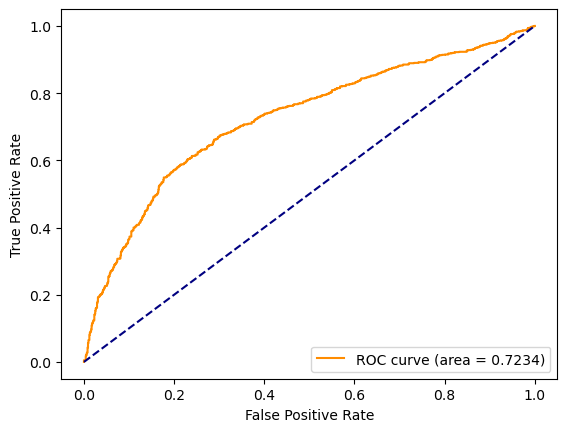

In [57]:
plot_ROC(train_stat, valid_stat, "")

In [76]:
def compute_fpr_tpr_or(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z):
    from sklearn.metrics import confusion_matrix
    
    thresholds = np.sort(np.concatenate((train_mope_z, valid_mope_z, train_loss_z, valid_loss_z)))
    fpr = []
    tpr = []
    for t in thresholds:
        train_pred = np.logical_or(train_mope_z < t, train_loss_z < t)
        valid_pred = np.logical_or(valid_mope_z < t, valid_loss_z < t)
        y_pred = np.concatenate((train_pred, valid_pred))
        y_real = np.concatenate((np.ones_like(train_mope_z), np.zeros_like(valid_mope_z)))
    
        tn, fp, fn, tp = confusion_matrix(y_real, y_pred).ravel()
        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))
    return np.array(fpr), np.array(tpr)

def compute_fpr_tpr_and(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z):
    from sklearn.metrics import confusion_matrix
    
    thresholds = np.sort(np.concatenate((train_mope_z, valid_mope_z, train_loss_z, valid_loss_z)))
    fpr = []
    tpr = []
    for t in thresholds:
        train_pred = np.logical_and(train_mope_z < t, train_loss_z < t)
        valid_pred = np.logical_and(valid_mope_z < t, valid_loss_z < t)
        y_pred = np.concatenate((train_pred, valid_pred))
        y_real = np.concatenate((np.ones_like(train_mope_z), np.zeros_like(valid_mope_z)))
    
        tn, fp, fn, tp = confusion_matrix(y_real, y_pred).ravel()
        fpr.append(fp / (fp + tn))
        tpr.append(tp / (tp + fn))
    return np.array(fpr), np.array(tpr)

In [77]:
def find_best_or(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z, start= 0.01, end = 100):
    best_auc = 0
    best_fpr, best_tpr = None, None
    for m in np.arange(start,end,1):
        fpr, tpr = compute_fpr_tpr_or(train_mope_z*m, valid_mope_z*m, train_loss_z, valid_loss_z)
        roc_auc  = auc(fpr, tpr)
        if roc_auc > best_auc:
            best_auc = roc_auc 
            best_fpr, best_tpr = fpr, tpr
    return best_auc, best_fpr, best_tpr

def find_best_and(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z, start= 0.01, end = 100):
    best_auc = 0
    best_fpr, best_tpr = None, None
    for m in np.arange(start,end,1):
        fpr, tpr = compute_fpr_tpr_and(train_mope_z*m, valid_mope_z*m, train_loss_z, valid_loss_z)
        roc_auc  = auc(fpr, tpr)
        if roc_auc > best_auc:
            best_auc = roc_auc 
            best_fpr, best_tpr = fpr, tpr
    return best_auc, best_fpr, best_tpr

In [ ]:
roc_auc, fpr, tpr = find_best_and(train_mope_z, valid_mope_z, train_loss_z, valid_loss_z)

In [ ]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("OR attacks")
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()